In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': True, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# (02) MARCS identifier linking

This notebook serves to map the metadata from ChIP-MS to MARCS gene identifiers.

## Configuration

In [2]:
import pathlib

INPUT_CHIP_MS_METADATA = pathlib.Path('outputs') / '01-extracting' / 'data_metadata.csv'
assert INPUT_CHIP_MS_METADATA.is_file()

INPUT_MARCS_GENE_LIST_MAP = pathlib.Path('data/from-marcs/table-s2.sheet.02.list_of_proteins.tsv.gz')
assert INPUT_MARCS_GENE_LIST_MAP.is_file()
    
INPUT_MARCS_TABLE_S3 = pathlib.Path('data/from-marcs-chipseq-analysis/table-s3.long.tsv.gz')
assert INPUT_MARCS_TABLE_S3.is_file()

In [3]:
import pathlib
OUTPUT_DIRECTORY = pathlib.Path('outputs') / '02-linking-to-MARCS'

if not OUTPUT_DIRECTORY.is_dir():
    OUTPUT_DIRECTORY.mkdir(parents=True)

## Reading datasets

We only need the metadata from ChIP MS, as we will be matching based on the Gene label column

In [4]:
data_metadata_chip_ms = pd.read_csv(INPUT_CHIP_MS_METADATA, index_col=0)
data_metadata_chip_ms

,# PSMs,# Peptides,# Unique Peptides,Accession,Coverage [%],Description,Gene
Label,,,,,,,
GBE1,2,2,2,Q04446,3,"1,4-alpha-glucan-branching enzyme OS=Homo sapi...",GBE1
EFTUD2,44,15,14,Q15029,23,116 kDa U5 small nuclear ribonucleoprotein com...,EFTUD2
YWHAB,44,9,4,P31946,43,14-3-3 protein beta/alpha OS=Homo sapiens OX=9...,YWHAB
YWHAE,53,11,8,P62258,49,14-3-3 protein epsilon OS=Homo sapiens OX=9606...,YWHAE
YWHAH,38,9,5,Q04917,42,14-3-3 protein eta OS=Homo sapiens OX=9606 GN=...,YWHAH
...,...,...,...,...,...,...,...
ZNF800,9,4,4,Q2TB10,9,Zinc finger protein 800 OS=Homo sapiens OX=960...,ZNF800
ZRANB2,6,4,4,O95218,10,Zinc finger Ran-binding domain-containing prot...,ZRANB2
ZFR,3,2,2,Q96KR1,4,Zinc finger RNA-binding protein OS=Homo sapien...,ZFR


We now load the MARCS data in order to create a mapping between MARCS gene labels and gene names

In [5]:
data_marcs_gene_list = pd.read_csv(INPUT_MARCS_GENE_LIST_MAP, sep='\t', index_col=0)
data_marcs_gene_list

,Gene names,Protein names,Complex memberships,Gene names (alternative),Majority protein IDs,Protein IDs
Gene label,,,,,,
A0A087X222,NaN,NaN,NaN,NaN,A0A087X222,A0A087X222
A0A0C4DFX4,NaN,NaN,NaN,NaN,A0A0C4DFX4,A0A0C4DFX4
A0A0C4DGP2,NaN,NaN,NaN,NaN,A0A0C4DGP2,A0A0C4DGP2
A0A0C4DGP5,NaN,NaN,NaN,NaN,A0A0C4DGP5,A0A0C4DGP5
AAAS,AAAS,Aladin,Nuclear pore complex,AAA;AAASb;ADRACALA;ADRACALIN;ALADIN;GL003,F8VZ44;Q9NRG9;H3BU82,F8VZ44;Q9NRG9;H3BU82
...,...,...,...,...,...,...
ZSCAN30,ZSCAN30,Zinc finger and SCAN domain-containing protein 30,NaN,ZNF-WYM;ZNF397OS;ZNF917,A0A0C4DGV0;Q86W11,A0A0C4DGV0;Q86W11
ZSCAN31,ZSCAN31,Zinc finger and SCAN domain-containing protein 31,NaN,ZNF20-Lp;ZNF310P;ZNF323,Q96LW9;C9J423,Q96LW9;C9J423;C9JUE1;C9JPM5
ZSCAN5A,ZSCAN5A,Zinc finger and SCAN domain-containing protein 5A,NaN,ZNF495;ZSCAN5,A0A0C4DGQ1;Q9BUG6;K7EIX9;K7EMC4,A0A0C4DGQ1;Q9BUG6;K7EIX9;K7EMC4;K7EQW6;K7ESN6;...


Let's create a map between MARCS Gene Labels and Majority Protein IDs

In [6]:
data_marcs_uniprot_id_map = data_marcs_gene_list['Majority protein IDs'].str.split(';', expand=True).stack().reset_index()
data_marcs_uniprot_id_map.columns = ['marcs_gene_label', 'ix', 'uniprot_id']
data_marcs_uniprot_id_map = data_marcs_uniprot_id_map[['marcs_gene_label', 'uniprot_id']].drop_duplicates()
data_marcs_uniprot_id_map

,marcs_gene_label,uniprot_id
0,A0A087X222,A0A087X222
1,A0A0C4DFX4,A0A0C4DFX4
2,A0A0C4DGP2,A0A0C4DGP2
3,A0A0C4DGP5,A0A0C4DGP5
4,AAAS,F8VZ44
...,...,...
4009,ZSCAN5A,K7EIX9
4010,ZSCAN5A,K7EMC4
4011,ZWINT,O95229
4012,ZWINT,A6NH27


And another one between MARCS gene labels and gene names

In [7]:
data_marcs_gene_name_map = data_marcs_gene_list['Gene names'].dropna().str.split(';', expand=True).stack().reset_index()
data_marcs_gene_name_map.columns = ['marcs_gene_label', 'ix', 'gene_name']
data_marcs_gene_name_map = data_marcs_gene_name_map[['marcs_gene_label', 'gene_name']]
data_marcs_gene_name_map['gene_name_lowercase'] = data_marcs_gene_name_map['gene_name'].str.lower()
data_marcs_gene_name_map

,marcs_gene_label,gene_name,gene_name_lowercase
0,AAAS,AAAS,aaas
1,AATF,AATF,aatf
2,ABCF2,ABCF2,abcf2
3,ABHD12,ABHD12,abhd12
4,ABRAXAS1,ABRAXAS1,abraxas1
...,...,...,...
2013,ZSCAN30,ZSCAN30,zscan30
2014,ZSCAN31,ZSCAN31,zscan31
2015,ZSCAN5A,ZSCAN5A,zscan5a
2016,ZWINT,ZWINT,zwint


## Mapping ChIP-MS labels to MARCS 

### via uniprot IDs

We start by mapping the ChIP-MS proteins to MARCS by their uniprot accession number.

Unlike marcs data the accession column in ChIP-MS contains only one protein id.

We can verify it by checking the maximum length of the strings in this column:

In [8]:
data_metadata_chip_ms['Accession'].str.len().max()

10

The maximum length columns are just proteins with long accessions:

In [9]:
data_metadata_chip_ms[data_metadata_chip_ms['Accession'].str.len() == 10]

,# PSMs,# Peptides,# Unique Peptides,Accession,Coverage [%],Description,Gene
Label,,,,,,,
IGLV3-10,2,2,2,A0A075B6K4,14,Immunoglobulin lambda variable 3-10 OS=Homo sa...,IGLV3-10
IGKV2D-24,30,4,3,A0A075B6R9,24,Probable non-functional immunoglobulin kappa v...,IGKV2D-24


We therefore create the following data frame for ChIP-MS mappings:

In [10]:
data_chip_ms_accession_gene_map = data_metadata_chip_ms[['Accession', 'Gene']].reset_index()
data_chip_ms_accession_gene_map.columns = ['chip_ms_label', 'chip_ms_accession', 'chip_ms_gene']
data_chip_ms_accession_gene_map['chip_ms_gene_lowercase'] = data_chip_ms_accession_gene_map['chip_ms_gene'].str.lower()
data_chip_ms_accession_gene_map

,chip_ms_label,chip_ms_accession,chip_ms_gene,chip_ms_gene_lowercase
0,GBE1,Q04446,GBE1,gbe1
1,EFTUD2,Q15029,EFTUD2,eftud2
2,YWHAB,P31946,YWHAB,ywhab
3,YWHAE,P62258,YWHAE,ywhae
4,YWHAH,Q04917,YWHAH,ywhah
...,...,...,...,...
1041,ZNF800,Q2TB10,ZNF800,znf800
1042,ZRANB2,O95218,ZRANB2,zranb2
1043,ZFR,Q96KR1,ZFR,zfr
1044,AZGP1,P25311,AZGP1,azgp1


There is some overlap between the accessions in MARCS and in metadata chip_ms


Overlaps between Uniprot IDs in MARCS data and Uniprot IDs observed in the ChIP-MS dataset.
Uniprot IDs are required to match exactly.



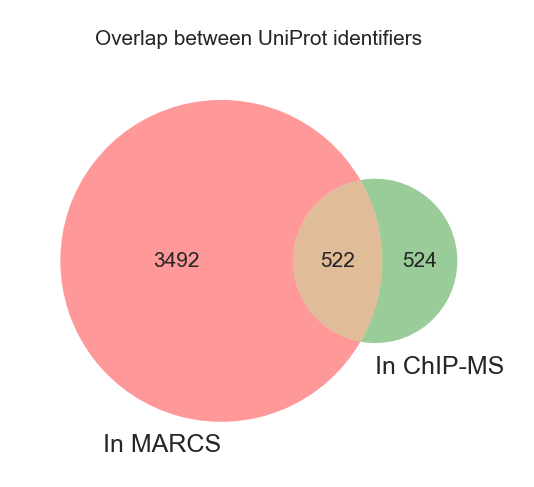

In [11]:
from matplotlib_venn import venn2

venn2((set(data_marcs_uniprot_id_map['uniprot_id']), set(data_chip_ms_accession_gene_map['chip_ms_accession'])), 
      set_labels=("In MARCS", "In ChIP-MS"))
plt.title("Overlap between UniProt identifiers")
_fname = OUTPUT_DIRECTORY / '01-venn-diagram-of-uniprot-id-overlaps.pdf'
_caption = f"""
Overlaps between Uniprot IDs in MARCS data and Uniprot IDs observed in the ChIP-MS dataset.
Uniprot IDs are required to match exactly.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

In [12]:
marcs_to_chip_ms_map_by_accession = pd.merge(
    data_marcs_uniprot_id_map,
    data_chip_ms_accession_gene_map[['chip_ms_label', 'chip_ms_accession']],
    left_on='uniprot_id',
    right_on='chip_ms_accession'
)

marcs_to_chip_ms_map_by_accession['mapped_via'] = 'Accession'
marcs_to_chip_ms_map_by_accession

,marcs_gene_label,uniprot_id,chip_ms_label,chip_ms_accession,mapped_via
0,ACIN1 (1),Q9UKV3,ACIN1,Q9UKV3,Accession
1,ACTB,P60709,ACTB,P60709,Accession
2,ACTBL2,Q562R1,ACTBL2,Q562R1,Accession
3,ACTL6A,O96019,ACTL6A,O96019,Accession
4,"ACT[A1,A2,C1,G2]",P62736,ACTA2,P62736,Accession
...,...,...,...,...,...
517,ZMYND11,Q15326,ZMYND11,Q15326,Accession
518,ZNF326,Q5BKZ1,ZNF326,Q5BKZ1,Accession
519,ZNF512,Q96ME7,ZNF512,Q96ME7,Accession
520,ZNF512B,Q96KM6,ZNF512B,Q96KM6,Accession


### via gene names

Alternatively, we can align MARCS data to ChIP-MS via the parsed gene name column.

This is a less strict mapping, and is mostly useful for when we hav edifferent variants of the same Gene in MARCS, e.g. PHF8 (1) / PHF8 (2) that may not necessarily correspond 1:1 in ChIP-MS.


We can see the quick overlap:


Overlaps between Gene names in MARCS data and gene names observed in the ChIP-MS dataset.
Gene names are equired to match exactly.



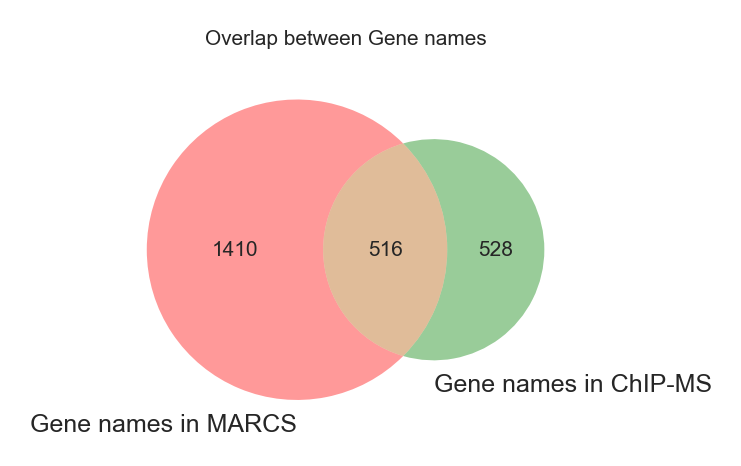

In [13]:
from matplotlib_venn import venn2

in_marcs = set(data_marcs_gene_name_map['gene_name_lowercase'].dropna().unique())
in_chip_ms = set(data_chip_ms_accession_gene_map['chip_ms_gene_lowercase'].dropna().unique())

venn2((in_marcs, in_chip_ms), set_labels=['Gene names in MARCS', 'Gene names in ChIP-MS'])

_fname = OUTPUT_DIRECTORY / '01-venn-diagram-of-gene-name-overlaps.pdf'
_caption = f"""
Overlaps between Gene names in MARCS data and gene names observed in the ChIP-MS dataset.
Gene names are equired to match exactly.
"""
plt.title("Overlap between Gene names")
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

We can now make a similar mapping like we did with Uniprot IDs

In [14]:
marcs_to_chip_ms_map_by_gene_name = pd.merge(
    data_marcs_gene_name_map,
    data_chip_ms_accession_gene_map[['chip_ms_label', 'chip_ms_gene_lowercase']],
    left_on='gene_name_lowercase',
    right_on='chip_ms_gene_lowercase'
)

marcs_to_chip_ms_map_by_gene_name['mapped_via'] = 'Gene name'
marcs_to_chip_ms_map_by_gene_name

,marcs_gene_label,gene_name,gene_name_lowercase,chip_ms_label,chip_ms_gene_lowercase,mapped_via
0,ACIN1 (1),ACIN1,acin1,ACIN1,acin1,Gene name
1,ACIN1 (2),ACIN1,acin1,ACIN1,acin1,Gene name
2,ACIN1 (3),ACIN1,acin1,ACIN1,acin1,Gene name
3,ACIN1 (4),ACIN1,acin1,ACIN1,acin1,Gene name
4,ACTB,ACTB,actb,ACTB,actb,Gene name
...,...,...,...,...,...,...
558,ZMYND11,ZMYND11,zmynd11,ZMYND11,zmynd11,Gene name
559,ZNF326,ZNF326,znf326,ZNF326,znf326,Gene name
560,ZNF512,ZNF512,znf512,ZNF512,znf512,Gene name
561,ZNF512B,ZNF512B,znf512b,ZNF512B,znf512b,Gene name


Let's see how much of this mapping overlaps


Distribution of the mappability of MARCS gene labels to the ChIP-MS datasets.
Gene names are equired to match exactly.



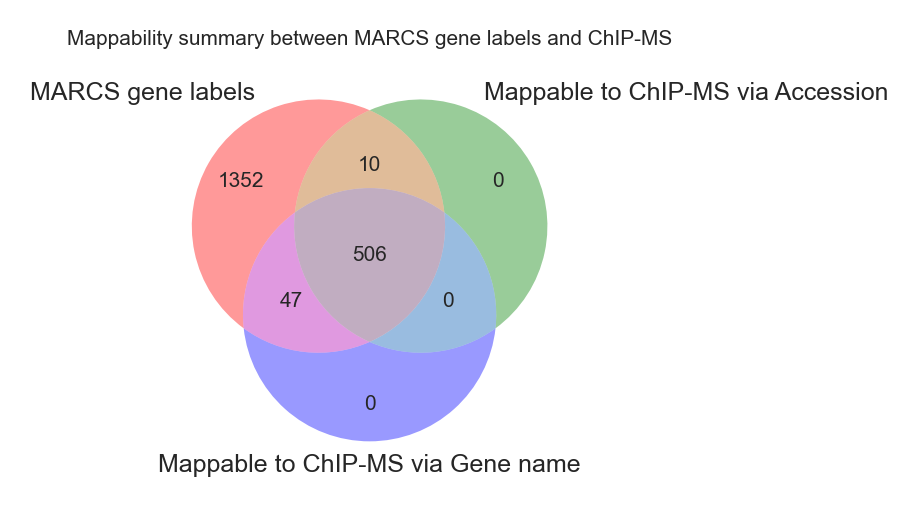

In [15]:
all_marcs_gene_labels = set(data_marcs_gene_list.index)
mapped_via_accession = set(marcs_to_chip_ms_map_by_accession['marcs_gene_label'].unique())
mapped_via_gene_name = set(marcs_to_chip_ms_map_by_gene_name['marcs_gene_label'].unique())

from matplotlib_venn import venn3_unweighted

venn3_unweighted(
    (all_marcs_gene_labels, mapped_via_accession, mapped_via_gene_name),
    set_labels=("MARCS gene labels", "Mappable to ChIP-MS via Accession", "Mappable to ChIP-MS via Gene name"),
)

plt.title("Mappability summary between MARCS gene labels and ChIP-MS")

_fname = OUTPUT_DIRECTORY / '01-venn-diagram-of-gene-label-mappability.pdf'
_caption = f"""
Distribution of the mappability of MARCS gene labels to the ChIP-MS datasets.
Gene names are equired to match exactly.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

In [16]:
mappable_via_accession_only = mapped_via_accession - mapped_via_gene_name
mappable_via_accession_only

{'EPRS',
 'H1F0',
 'H1FX',
 'H2AFV/H2AFZ',
 'HIST1H1B',
 'HIST1H2A[B,E]/HIST3H2A',
 'HIST1H2A[G-M]/HIST2H2A[A3,A4,C]/H2AFJ',
 'HIST1H2B[C,D,E,F,G,I]',
 'HIST[1H4A,1H4B,1H4C,1H4E,1H4F,1H4H,1H4I,1H4L,2H4A,4H4]',
 'HIST[2H3A,2H3C,2H3D,3H3]'}

In [17]:
mappable_via_gene_name_only = mapped_via_gene_name - mapped_via_accession
mappable_via_gene_name_only

{'ACIN1 (2)',
 'ACIN1 (3)',
 'ACIN1 (4)',
 'ALYREF (2)',
 'BCLAF1 (2)',
 'CALM[1-3]',
 'CENPV (2)',
 'DDX17 (1)',
 'DDX3X (2)',
 'DDX46 (1)',
 'DNMT1 (2)',
 'EIF4G2',
 'EWSR1 (2)',
 'HNRNPAB',
 'HNRNPC (1)',
 'HNRNPDL (2)',
 'HNRNPM (2)',
 'KAT7 (2)',
 'LMNA (2)',
 'LMO7',
 'MECP2 (2)',
 'NCL (2)',
 'NOLC1 (2)',
 'NOLC1 (3)',
 'NOP2 (2)',
 'NUMA1 (2)',
 'NUMA1 (3)',
 'PABPN1 (2)',
 'PHF8 (2)',
 'PSIP1 (2)',
 'RBM39 (2)',
 'RCC1 (2)',
 'SF1 (2)',
 'SF1 (3)',
 'SMARCA4 (2)',
 'SMARCC2 (1)',
 'SON (2)',
 'TCOF1 (2)',
 'TMPO (3)',
 'TOP2B (1)',
 'TOR1AIP1 (2)',
 'TRIP12 (2)',
 'TRIP12 (3)',
 'UBTF (2)',
 'YLPM1 (2)',
 'YLPM1 (3)',
 'ZC3H18 (1)'}

We can now compute the final mapping by concatenating the two dataframes:

In [18]:
full_gene_label_map = pd.concat(
    (
        marcs_to_chip_ms_map_by_accession[['marcs_gene_label', 'chip_ms_label', 'mapped_via']],
        marcs_to_chip_ms_map_by_gene_name[['marcs_gene_label', 'chip_ms_label', 'mapped_via']]
    ),
    ignore_index=True
)
full_gene_label_map

,marcs_gene_label,chip_ms_label,mapped_via
0,ACIN1 (1),ACIN1,Accession
1,ACTB,ACTB,Accession
2,ACTBL2,ACTBL2,Accession
3,ACTL6A,ACTL6A,Accession
4,"ACT[A1,A2,C1,G2]",ACTA2,Accession
...,...,...,...
1080,ZMYND11,ZMYND11,Gene name
1081,ZNF326,ZNF326,Gene name
1082,ZNF512,ZNF512,Gene name
1083,ZNF512B,ZNF512B,Gene name


And sorting out the duplication by concatenating the 'mapped_via' column:

In [19]:
full_gene_label_map = full_gene_label_map.groupby(['marcs_gene_label', 'chip_ms_label'])['mapped_via'].apply(lambda x: ';'.join(sorted(x.unique()))).reset_index()
full_gene_label_map

,marcs_gene_label,chip_ms_label,mapped_via
0,ACIN1 (1),ACIN1,Accession;Gene name
1,ACIN1 (2),ACIN1,Gene name
2,ACIN1 (3),ACIN1,Gene name
3,ACIN1 (4),ACIN1,Gene name
4,ACTB,ACTB,Accession;Gene name
...,...,...,...
568,ZMYND11,ZMYND11,Accession;Gene name
569,ZNF326,ZNF326,Accession;Gene name
570,ZNF512,ZNF512,Accession;Gene name
571,ZNF512B,ZNF512B,Accession;Gene name


These counts should be similar to the venn diagram above (but not exact, due to one-to-many mappings):

In [20]:
full_gene_label_map['mapped_via'].value_counts()

Accession;Gene name    512
Gene name               51
Accession               10
Name: mapped_via, dtype: int64

Speicfically, some ChIP MS labels map to multiple MARCS labels:

In [21]:
mapping_counts_chip_ms_to_marcs = full_gene_label_map.groupby('chip_ms_label')['marcs_gene_label'].nunique()
mapping_counts_chip_ms_to_marcs.loc[mapping_counts_chip_ms_to_marcs > 1]

chip_ms_label
ACIN1       4
ALYREF      2
BCLAF1      2
CENPV       2
DDX17       2
DDX3X       2
DDX46       2
DNMT1       2
EWSR1       2
HNRNPC      2
HNRNPDL     2
HNRNPM      2
KAT7        2
LMNA        2
MECP2       2
NCL         2
NOLC1       3
NOP2        2
NUMA1       3
PABPN1      2
PHF8        2
PSIP1       2
RBM39       2
RCC1        2
SF1         3
SMARCA4     2
SMARCC2     2
SON         2
TCOF1       2
TMPO (1)    3
TMPO (2)    3
TOP2B       2
TOR1AIP1    2
TRIP12      3
UBTF        2
YLPM1       3
ZC3H18      2
Name: marcs_gene_label, dtype: int64

And some of the MARCS labels map to multiple ChIP-MS labels.
This, unfortunately, is unavoidable.

In [22]:
mapping_counts_marcs_to_chip_ms = full_gene_label_map.groupby('marcs_gene_label')['chip_ms_label'].nunique()
mapping_counts_marcs_to_chip_ms.loc[mapping_counts_marcs_to_chip_ms > 1]

marcs_gene_label
HLA-A/HLA-C          2
PRDX1/PRDX4          2
RPL36A/RPL36AL       2
TIA1/TIAL1           2
TMPO (1)             2
TMPO (2)             2
TMPO (3)             2
TUBA[1A,1B,1C,4A]    3
TUBB/TUBB[2A,2B]     2
Name: chip_ms_label, dtype: int64

Save this mapping to CSV

In [23]:
full_gene_label_map.to_csv(OUTPUT_DIRECTORY / '02-marcs-to-chip-ms-mapping.csv')

## Linking with MARCS Features

As a final step in this notebook we will map the MARCS Feature effect data (from table S3) to ChIP-MS identifiers.

We will again make use the dataframe processed in the ChIP-Seq pipeline as it is easier to ingest.

In [24]:
marcs_table_s3 = pd.read_csv(INPUT_MARCS_TABLE_S3, sep='\t')
marcs_table_s3

,Gene label,Symbol,Other Names,Name,Complex,Effect,95% CI (+/-),logFC variance,t statistic (moderated),P value,...,H03M-H03 (H3K27me3 + me-DNA),H07M-H07 (H4K20me3 + me-DNA),H39M-H39 (H4K20me2 + me-DNA),H46M-H46 (H3K27me2 + me-DNA),H47M-H47 (H3K9me2 + me-DNA),H04M-H04 (H3K9me3/K27me3 + me-DNA),H08M-H08 (H3K9me3/K27me3/H4K20me3 + me-DNA),significant,significant_category_weak,significant_category_strong
0,TOP2B (2),TOP2B,TOPIIB;top2beta,DNA topoisomerase II beta,NaN,-2.044945,0.217350,0.011860,-21.419160,8.637891e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Excluded,Strongly excluded
1,CTDSPL2,CTDSPL2,HSPC058;HSPC129,CTD small phosphatase like 2,NaN,-2.796458,0.278671,0.019496,-22.845354,4.992383e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Excluded,Strongly excluded
2,KANSL3,KANSL3,KIAA1310;NSL3;Rcd1,KAT8 regulatory NSL complex subunit 3,NSL,2.081084,0.218283,0.011962,21.704575,7.718872e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited
3,TOP2B (1),TOP2B,TOPIIB;top2beta,DNA topoisomerase II beta,NaN,-2.068321,0.270416,0.018358,-17.412682,4.982978e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Excluded,Strongly excluded
4,ZMYM3,ZMYM3,DXS6673E;MYM;XFIM;ZNF198L2;ZNF261,zinc finger MYM-type containing 3,BHC,0.496272,0.068820,0.001189,16.416200,8.158507e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Recruited,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22361,RPL37A,RPL37A,L37A,ribosomal protein L37a,60S Ribosomal subunit,0.000179,0.088129,0.001992,0.004169,9.967039e-01,...,-0.068296,0.056657,-0.060008,-0.034585,-0.146044,0.020548,-0.076245,False,Neither,Neither
22362,TFIP11,TFIP11,NTR1;STIP;STIP-1;Spp382;TIP39;bK445C9.6,tuftelin interacting protein 11,C complex spliceosome;Spliceosome,0.000171,0.077671,0.001548,0.004507,9.964371e-01,...,-0.019010,0.081675,0.119961,-0.073559,-0.166437,0.035080,0.095642,False,Neither,Neither
22363,CTDSPL2,CTDSPL2,HSPC058;HSPC129,CTD small phosphatase like 2,NaN,0.000284,0.145458,0.005428,0.004003,9.968355e-01,...,-0.385522,-0.081446,0.200713,0.201322,0.126154,0.097792,-0.381070,False,Neither,Neither
22364,NSA2,NSA2,CDK105;HCL-G1;HCLG1;HUSSY-29;HUSSY29;TINP1,NSA2 ribosome biogenesis factor,NaN,-0.000185,0.097859,0.002457,-0.003885,9.969291e-01,...,-0.135045,-0.240801,0.116168,-0.140587,0.047419,0.063146,0.196994,False,Neither,Neither


Before joining, let's quickly count the number of genes for each feature and `significant_category_strong`:

In [25]:
counts_marcs_total = marcs_table_s3.groupby(['Feature', 'significant_category_strong'])['Gene label'].nunique()
counts_marcs_total

Feature      significant_category_strong
H2A.Z        Neither                        1586
             Strongly excluded                11
             Strongly recruited               17
H3K27ac      Neither                        1063
             Strongly recruited                9
H3K27me2     Neither                        1062
             Strongly recruited                6
H3K27me3     Neither                        1652
             Strongly excluded                 1
             Strongly recruited               22
H3K4me1      Neither                        1663
             Strongly excluded                 3
             Strongly recruited                1
H3K4me3      Neither                        1563
             Strongly excluded                32
             Strongly recruited               45
H3K9acK14ac  Neither                        1601
             Strongly recruited               45
H3K9me2      Neither                        1012
             Strongly recrui

Now let's joint the table S3 with the label translation map.
Again, inner join is fine here as we only can use the matching data anyway

In [26]:
marcs_table_s3_merged = pd.merge(
    marcs_table_s3, full_gene_label_map, 
    left_on='Gene label', right_on='marcs_gene_label', 
    how='inner'
)

In [27]:
marcs_table_s3_merged.query('Feature == "H3K4me3" and significant_category_strong == "Strongly recruited"')

,Gene label,Symbol,Other Names,Name,Complex,Effect,95% CI (+/-),logFC variance,t statistic (moderated),P value,...,H46M-H46 (H3K27me2 + me-DNA),H47M-H47 (H3K9me2 + me-DNA),H04M-H04 (H3K9me3/K27me3 + me-DNA),H08M-H08 (H3K9me3/K27me3/H4K20me3 + me-DNA),significant,significant_category_weak,significant_category_strong,marcs_gene_label,chip_ms_label,mapped_via
1264,UBTF (2),UBTF,CONDBA;NOR-90;UBF;UBF-1;UBF1;UBF2,upstream binding transcription factor,NaN,1.822919,0.893027,0.202489,4.356323,5.822516e-04,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,UBTF (2),UBTF,Gene name
1279,BRPF1,BRPF1,BR140;IDDDFP,bromodomain and PHD finger containing 1,MOZ/MORF,1.403713,0.190816,0.009245,15.699273,1.256639e-10,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,BRPF1,BRPF1,Accession;Gene name
1583,UBTF (1),UBTF,CONDBA;NOR-90;UBF;UBF-1;UBF1;UBF2,upstream binding transcription factor,NaN,1.777296,0.897825,0.204670,4.224597,7.573972e-04,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,UBTF (1),UBTF,Accession;Gene name
1965,SIN3A,SIN3A,WITKOS,SIN3 transcription regulator family member A,N-CoR2;SIN3A/B,1.346486,0.315362,0.025252,9.111918,1.879065e-07,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,SIN3A,SIN3A,Accession;Gene name
2249,PHF8 (1),PHF8,JHDM1F;KDM7B;MRXSSD;ZNF422,PHD finger protein 8,NaN,2.768282,0.320045,0.026009,18.453477,1.208743e-11,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,PHF8 (1),PHF8,Accession;Gene name
2906,PHF8 (2),PHF8,JHDM1F;KDM7B;MRXSSD;ZNF422,PHD finger protein 8,NaN,2.562645,0.669508,0.113811,8.168643,7.347372e-07,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,PHF8 (2),PHF8,Gene name
5306,CHD1,CHD1,CHD-1;PILBOS,chromodomain helicase DNA binding protein 1,NaN,2.677466,0.628900,0.100423,9.085724,1.948913e-07,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,CHD1,CHD1,Accession;Gene name
5828,ING1,ING1,p24ING1c;p33;p33ING1;p33ING1b;p47;p47ING1a,inhibitor of growth family member 1,SIN3A/B,1.625569,0.311236,0.024595,11.146341,1.365112e-08,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,ING1,ING1,Accession;Gene name
6078,SPIN1,SPIN1,SPIN;TDRD24,spindlin 1,NaN,3.691420,0.570061,0.082512,13.819399,7.396855e-10,...,NaN,NaN,NaN,NaN,True,Recruited,Strongly recruited,SPIN1,SPIN1,Accession;Gene name


Let's re-count the category occupancies so we can see how much of each feature we cover

In [28]:
counts_marcs_matched = marcs_table_s3_merged.groupby(['Feature', 'significant_category_strong'])['Gene label'].nunique()
counts_marcs_matched

Feature      significant_category_strong
H2A.Z        Neither                        487
             Strongly excluded                3
H3K27ac      Neither                        426
             Strongly recruited               3
H3K27me2     Neither                        423
H3K27me3     Neither                        506
H3K4me1      Neither                        504
             Strongly excluded                1
H3K4me3      Neither                        487
             Strongly excluded                7
             Strongly recruited               9
H3K9acK14ac  Neither                        490
             Strongly recruited              12
H3K9me2      Neither                        412
             Strongly recruited               4
H3K9me3      Neither                        510
             Strongly recruited               9
H3ac         Neither                        476
             Strongly excluded                1
             Strongly recruited              14

Let's make this into a table/figure

In [29]:
feature_matching_statistics = pd.DataFrame({
    'total': counts_marcs_total, 
    'matched_in_chip_ms': counts_marcs_matched,
}).fillna(0).astype(int)
feature_matching_statistics['fraction'] = feature_matching_statistics['matched_in_chip_ms'] / feature_matching_statistics['total']
feature_matching_statistics['annot'] = feature_matching_statistics.apply(lambda x: '{:,}/{:,} ({:.1%})'.format(int(x['matched_in_chip_ms']), int(x['total']), x['fraction']), axis=1)
feature_matching_statistics

total  matched_in_chip_ms  fraction  \
Feature     significant_category_strong                                        
H2A.Z       Neither                       1586                 487  0.307062   
            Strongly excluded               11                   3  0.272727   
            Strongly recruited              17                   0  0.000000   
H3K27ac     Neither                       1063                 426  0.400753   
            Strongly recruited               9                   3  0.333333   
H3K27me2    Neither                       1062                 423  0.398305   
            Strongly recruited               6                   0  0.000000   
H3K27me3    Neither                       1652                 506  0.306295   
            Strongly excluded                1                   0  0.000000   
            Strongly recruited              22                   0  0.000000   
H3K4me1     Neither                       1663                 504  0.303067   
            Strongly excluded                3                   1  0.333333   
            Strongly recruited               1                   0  0.000000   
H3K4me3     Neither                       1563                 487  0.311580   
            Strongly excluded               32                   7  0.218750   
            Strongly recruited              45                   9  0.200000   
H3K9acK14ac Neither                       1601                 490  0.306059   
            Strongly recruited              45                  12  0.266667   
H3K9me2     Neither                       1012                 412  0.407115   
            Strongly recruited              11                   4  0.363636   
H3K9me3     Neither                       1679                 510  0.303752   
            Strongly recruited              22                   9  0.409091   
H3ac        Neither                       1463                 476  0.325359   
            Strongly excluded                1                   1  1.000000   
            Strongly recruited             120                  14  0.116667   
H4K16ac     Neither                       1605                 493  0.307165   
            Strongly excluded                2                   0  0.000000   
            Strongly recruited               1                   1  1.000000   
H4K20me2    Neither                       1626                 505  0.310578   
            Strongly excluded               10                   1  0.100000   
            Strongly recruited              24                   0  0.000000   
H4K20me3    Neither                       1635                 504  0.308257   
            Strongly excluded                9                   0  0.000000   
            Strongly recruited               1                   0  0.000000   
H4ac        Neither                       1465                 471  0.321502   
            Strongly excluded                2                   1  0.500000   
            Strongly recruited              91                   9  0.098901   
meDNA       Neither                       1114                 434  0.389587   
            Strongly excluded               49                   4  0.081633   
            Strongly recruited              42                  14  0.333333   

                                                     annot  
Feature     significant_category_strong                     
H2A.Z       Neither                      487/1,586 (30.7%)  
            Strongly excluded                 3/11 (27.3%)  
            Strongly recruited                 0/17 (0.0%)  
H3K27ac     Neither                      426/1,063 (40.1%)  
            Strongly recruited                 3/9 (33.3%)  
H3K27me2    Neither                      423/1,062 (39.8%)  
            Strongly recruited                  0/6 (0.0%)  
H3K27me3    Neither                      506/1,652 (30.6%)  
            Strongly excluded                   0/1 (0.0%)  
         

For further cells we don't need the category "Neither":

In [30]:
feature_matching_statistics_no_neither = feature_matching_statistics.loc(axis=0)[:, ['Strongly recruited', 'Strongly excluded']].copy()

In [31]:
feature_matching_statistics_no_neither

,,total,matched_in_chip_ms,fraction,annot
Feature,significant_category_strong,,,,
H2A.Z,Strongly recruited,17,0,0.000000,0/17 (0.0%)
H3K27ac,Strongly recruited,9,3,0.333333,3/9 (33.3%)
H3K27me2,Strongly recruited,6,0,0.000000,0/6 (0.0%)
H3K27me3,Strongly recruited,22,0,0.000000,0/22 (0.0%)
H3K4me1,Strongly recruited,1,0,0.000000,0/1 (0.0%)
H3K4me3,Strongly recruited,45,9,0.200000,9/45 (20.0%)
H3K9acK14ac,Strongly recruited,45,12,0.266667,12/45 (26.7%)
H3K9me2,Strongly recruited,11,4,0.363636,4/11 (36.4%)
H3K9me3,Strongly recruited,22,9,0.409091,9/22 (40.9%)


Make a nice heatmap:


Fraction of proteins in MARCS feature categories that were matched in ChIP-MS.

The colour highlights the fraction using the viridis colour scale on the right.
The annotated textdisplays the actual numbers of matched proteins (first number),
the total number of proteins in the category (second number, after slash), 
and the percentage of matched proteins between MARCS feature and ChIP-MS.

Heatmap is sorted by number of matched proteins, descending.



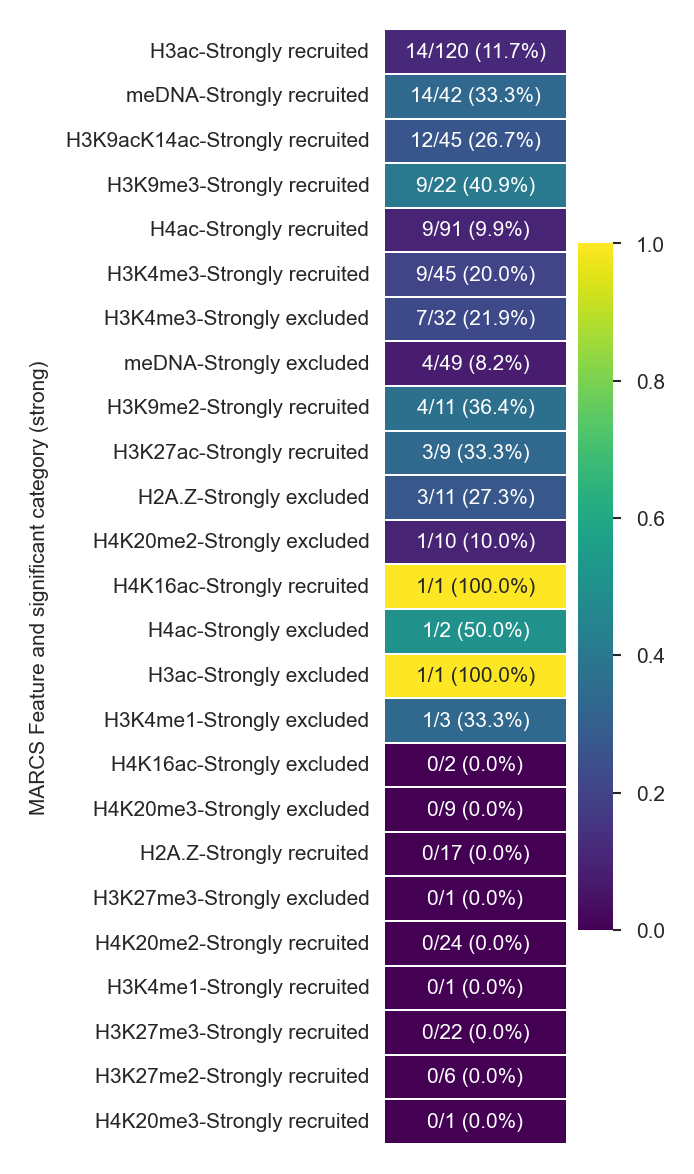

In [32]:
figure = plt.figure(figsize=(5*FIVE_MM_IN_INCH, 25*FIVE_MM_IN_INCH))

# Don't show "neither"
_df = feature_matching_statistics_no_neither.sort_values(by='matched_in_chip_ms', ascending=False)

_hmap = sns.heatmap(
    _df[['fraction']],
    cmap='viridis',
    annot=_df[['annot']],
    fmt='',
    linewidth=0.1,
    robust=True,
)

_hmap.yaxis.set_tick_params(length=0)
_hmap.xaxis.set_tick_params(length=0)
_hmap.set_xticks([])
_hmap.set_ylabel("MARCS Feature and significant category (strong)")

_fname = OUTPUT_DIRECTORY / '02-fraction-of-matched-proteins-in-marcs-categories.pdf'
_caption = """
Fraction of proteins in MARCS feature categories that were matched in ChIP-MS.

The colour highlights the fraction using the viridis colour scale on the right.
The annotated textdisplays the actual numbers of matched proteins (first number),
the total number of proteins in the category (second number, after slash), 
and the percentage of matched proteins between MARCS feature and ChIP-MS.

Heatmap is sorted by number of matched proteins, descending.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

These numbers are fairly low.  We can quickly estimate how these numbers relate to what we would expect by pure chance.

If we were to assume a hypergeometric distribution with the following parameters:

In [33]:
# population size - number of all unique Gene labels in MARCS
hypergeom_N = len(data_marcs_gene_list.index)
# number of "successes" - number of unique gene labels in the mapping
hypergeom_K = full_gene_label_map['marcs_gene_label'].nunique() 

f'N={hypergeom_N}, K={hypergeom_K}'

'N=1915, K=563'

Then for a MARCS category of size $n$ (column `total`) we would expect $E[k] = n \times K/N$ proteins to match in the dataset.

The direction and level of under-representation can be judged by computing a pearson residual, given the observed number of matched proteins in a category $k$ (column `matched_in_chip_ms`):

$$
\text{Pearson residual} = \frac{k - E[k]}{\sqrt{E[k]}}
$$

In [34]:
feature_matching_statistics_no_neither['expected_number_of_matched'] = hypergeom_K/hypergeom_N * feature_matching_statistics_no_neither['total']
feature_matching_statistics_no_neither['pearson_residual'] = (feature_matching_statistics_no_neither['matched_in_chip_ms'] - feature_matching_statistics_no_neither['expected_number_of_matched']) / feature_matching_statistics_no_neither['expected_number_of_matched'].apply(np.sqrt)

feature_matching_statistics_no_neither['annot_2'] = feature_matching_statistics_no_neither['annot'].str.cat(
    feature_matching_statistics_no_neither['expected_number_of_matched'].apply(lambda x: f'(Exp = {x:.1f})'),
    sep=' '
)

In [35]:
feature_matching_statistics_no_neither.sort_values(by='pearson_residual', ascending=False)

,,total,matched_in_chip_ms,fraction,annot,expected_number_of_matched,pearson_residual,annot_2
Feature,significant_category_strong,,,,,,,
H3ac,Strongly excluded,1,1,1.000000,1/1 (100.0%),0.293995,1.302081,1/1 (100.0%) (Exp = 0.3)
H4K16ac,Strongly recruited,1,1,1.000000,1/1 (100.0%),0.293995,1.302081,1/1 (100.0%) (Exp = 0.3)
H3K9me3,Strongly recruited,22,9,0.409091,9/22 (40.9%),6.467885,0.995640,9/22 (40.9%) (Exp = 6.5)
H4ac,Strongly excluded,2,1,0.500000,1/2 (50.0%),0.587990,0.537308,1/2 (50.0%) (Exp = 0.6)
meDNA,Strongly recruited,42,14,0.333333,14/42 (33.3%),12.347781,0.470190,14/42 (33.3%) (Exp = 12.3)
H3K9me2,Strongly recruited,11,4,0.363636,4/11 (36.4%),3.233943,0.425986,4/11 (36.4%) (Exp = 3.2)
H3K27ac,Strongly recruited,9,3,0.333333,3/9 (33.3%),2.645953,0.217656,3/9 (33.3%) (Exp = 2.6)
H3K4me1,Strongly excluded,3,1,0.333333,1/3 (33.3%),0.881984,0.125664,1/3 (33.3%) (Exp = 0.9)
H2A.Z,Strongly excluded,11,3,0.272727,3/11 (27.3%),3.233943,-0.130090,3/11 (27.3%) (Exp = 3.2)



Fraction of proteins in MARCS feature categories that were matched in ChIP-MS.
The annotated text displays the actual numbers of matched proteins (first number),
the total number of proteins in the category (second number, after slash), 
the percentage of matched proteins between MARCS feature and ChIP-MS, 
and the expected number of matched proteins (if matching was random across the whole MARCS dataset - number prefixed by Exp). 

The colour highlights the pearson residual (observed-expected/sqrt(expected)). Red categories are strongly over-represented, blue - underrepresented

Heatmap is sorted by number of matched proteins, descending.



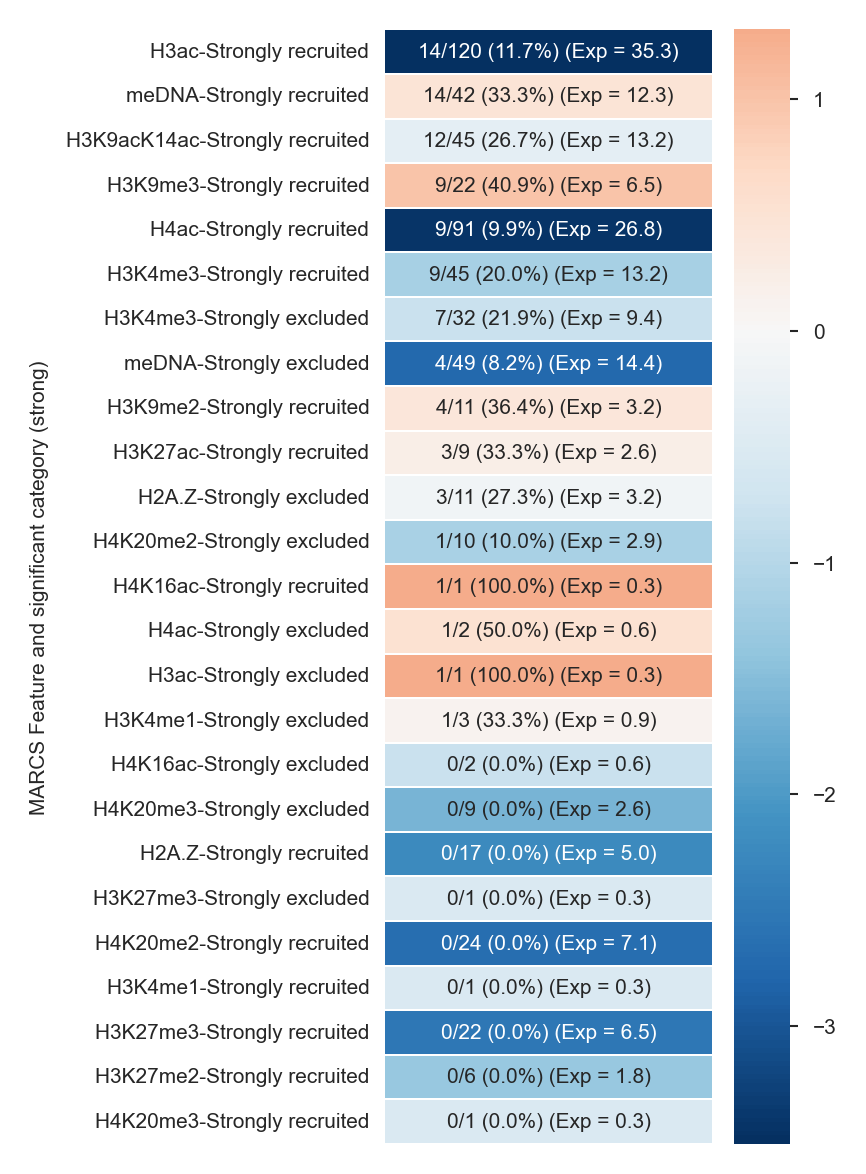

In [36]:
figure = plt.figure(figsize=(9*FIVE_MM_IN_INCH, 25*FIVE_MM_IN_INCH))

# Don't show "neither"
_df = feature_matching_statistics_no_neither.sort_values(by='matched_in_chip_ms', ascending=False)

_hmap = sns.heatmap(
    _df[['pearson_residual']],
    cmap='RdBu_r',
    annot=_df[['annot_2']],
    fmt='',
    linewidth=0.1,
    robust=True,
    center=0,
)

_hmap.yaxis.set_tick_params(length=0)
_hmap.xaxis.set_tick_params(length=0)
_hmap.set_xticks([])
_hmap.set_ylabel("MARCS Feature and significant category (strong)")

_fname = OUTPUT_DIRECTORY / '02-fraction-of-matched-proteins-in-marcs-categories-pearson-residuals.pdf'
_caption = """
Fraction of proteins in MARCS feature categories that were matched in ChIP-MS.
The annotated text displays the actual numbers of matched proteins (first number),
the total number of proteins in the category (second number, after slash), 
the percentage of matched proteins between MARCS feature and ChIP-MS, 
and the expected number of matched proteins (if matching was random across the whole MARCS dataset - number prefixed by Exp). 

The colour highlights the pearson residual (observed-expected/sqrt(expected)). Red categories are strongly over-represented, blue - underrepresented

Heatmap is sorted by number of matched proteins, descending.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

As shown above the coverage of the categories is not ideal, but we will have to live with this.

#### Reindexing to ChIP-MS notation

We will now "collapse" the MARCS Features data into the indices of ChIP-MS experiment so it is easier to work with in subsequent notebooks. We will use the same trick as ChIP-seq analysis.

In [37]:
marcs_feature_list = list(marcs_table_s3['Feature'].unique())

In [38]:
[c for c in marcs_table_s3.columns if not c.startswith('H')]

['Gene label',
 'Symbol',
 'Other Names',
 'Name',
 'Complex',
 'Effect',
 '95% CI (+/-)',
 'logFC variance',
 't statistic (moderated)',
 'P value',
 'P value (adjusted)',
 'Moderated t distribution dof',
 'Moderated t distribution stdev',
 'Feature',
 'significant',
 'significant_category_weak',
 'significant_category_strong']

In [39]:
# Only use the statistical columns
_merged_df = marcs_table_s3_merged.set_index(['Feature', 'Gene label'])[[
    'Effect',
    '95% CI (+/-)',
    'logFC variance',
    't statistic (moderated)',
    'P value',
    'P value (adjusted)',
    'Moderated t distribution dof',
    'Moderated t distribution stdev',
    'significant',
    'significant_category_weak',
    'significant_category_strong',
    'chip_ms_label',
]]

_column_to_reindex_to = 'chip_ms_label'

marcs_features_reindexed = {}

for feature in marcs_feature_list:
    feature_df = _merged_df.xs(feature, level='Feature')
    
    _df = []
    
    # Solve multimappings where one gene name maps to multiple MARCS gene names,
    # by taking the entry with lowest p-value
    for __, _subdata in feature_df.dropna(subset=['P value']).groupby(_column_to_reindex_to):
        _subdata = _subdata.loc[_subdata['P value'].idxmin()]
        _df.append(_subdata)
        
    _df = pd.DataFrame(_df).set_index(_column_to_reindex_to)
    assert not _df.index.duplicated().any()
    marcs_features_reindexed[feature] = _df
    
    
marcs_features_reindexed_wide = pd.concat(marcs_features_reindexed.values(), keys=marcs_features_reindexed.keys(), axis=1)
marcs_features_reindexed_wide = marcs_features_reindexed_wide.swaplevel(axis=1)
marcs_features_reindexed_wide.sort_index(axis=1, inplace=True)

In [40]:
marcs_features_reindexed_wide.columns.get_level_values(0).unique()

Index(['95% CI (+/-)', 'Effect', 'Moderated t distribution dof',
       'Moderated t distribution stdev', 'P value', 'P value (adjusted)',
       'logFC variance', 'significant', 'significant_category_strong',
       'significant_category_weak', 't statistic (moderated)'],
      dtype='object')

In [41]:
marcs_features_reindexed_wide

95% CI (+/-)                                                    \
                     H2A.Z   H3K27ac  H3K27me2  H3K27me3   H3K4me1   H3K4me3   
chip_ms_label                                                                  
ACIN1             0.211802  0.457351  0.200362  0.211652  0.269613  0.251001   
ACTA2             0.136765  0.159660  0.401742  0.105261  0.102875  0.115300   
ACTB              0.149708  0.228745  0.225918  0.114453  0.111949  0.152387   
ACTL6A            0.282852  0.143716  0.220205  0.081028  0.071553  0.118745   
ADAR              0.138593  0.205294  0.137140  0.089515  0.120810  0.182271   
...                    ...       ...       ...       ...       ...       ...   
SSB                    NaN       NaN       NaN       NaN       NaN       NaN   
TIA1                   NaN       NaN       NaN       NaN       NaN       NaN   
TIAL1                  NaN       NaN       NaN       NaN       NaN       NaN   
XPO1                   NaN       NaN       NaN       NaN       NaN       NaN   
ZNF512                 NaN  0.321946       NaN       NaN       NaN       NaN   

                                                         ...  \
              H3K9acK14ac   H3K9me2   H3K9me3      H3ac  ...   
chip_ms_label                                            ...   
ACIN1            0.145687  0.180162  0.231665  0.162215  ...   
ACTA2            0.140245  0.400128  0.147988  0.144921  ...   
ACTB             0.137878  0.179468  0.148311  0.180897  ...   
ACTL6A           0.128804  0.231306  0.093425  0.162082  ...   
ADAR             0.102996  0.147409  0.089110  0.101751  ...   
...                   ...       ...       ...       ...  ...   
SSB                   NaN       NaN  0.106573       NaN  ...   
TIA1                  NaN       NaN  0.109572       NaN  ...   
TIAL1                 NaN       NaN  0.109572       NaN  ...   
XPO1                  NaN       NaN  0.564072       NaN  ...   
ZNF512                NaN       NaN       NaN       NaN  ...   

              t statistic (moderated)                                  \
                              H3K4me3 H3K9acK14ac   H3K9me2   H3K9me3   
chip_ms_label                                                           
ACIN1                        2.950435   -2.996371  1.970440 -3.132679   
ACTA2                        2.974474   20.652988 -1.408574  0.621017   
ACTB                         2.222446   20.864091  1.126476  0.931822   
ACTL6A                       2.972668   19.593866 -1.219388 -0.122811   
ADAR                         2.751459   -4.002974  1.212874 -1.611738   
...                               ...         ...       ...       ...   
SSB                               NaN         NaN       NaN  0.606704   
TIA1                              NaN         NaN       NaN  2.377367   
TIAL1                             NaN         NaN       NaN  2.377367   
XPO1                              NaN         NaN       NaN -0.327175   
ZNF512                            NaN         NaN       NaN       NaN   

                                                                             
                    H3ac   H4K16ac  H4K20me2  H4K20me3      H4ac      meDNA  
chip_ms_label                                                                
ACIN1          -3.998931 -1.325173 -4.314919  3.179548  1.586292  -0.650315  
ACTA2          22.407837  2.748171  4.271652  0.000565  6.184322  -4.371167  
ACTB           17.952188  3.376827  3.599880 -0.312255  6.602180  -7.888528  
ACTL6A         16.775046  2.850633  3.277666 -0.078187  7.699869 -13.615176  
ADAR           -5.584594 -0.795835 -4.750740 -0.597883 -1.235132  -2.406844  
...                  ...       ...       ...       ...       ...        ...  
SSB                  NaN       NaN       NaN       NaN       NaN        NaN  
TIA1                 NaN       NaN       NaN       NaN       NaN        NaN  
TIAL1                NaN       NaN       NaN       NaN       NaN        NaN  
XPO1                 NaN       NaN -0

Quickly verify that feature category mapping is correct, that is all ChIP-MS labels marked to be in marcs category,
link to gene labels that are in this category. Additionally print out the ChIP-MS labels in each of the strong categories (for debugging reasons)

In [42]:
for marcs_feature in marcs_feature_list:
    for category in ['Neither', 'Strongly recruited', 'Strongly excluded']:
        
        available_marcs_labels = set(marcs_table_s3[(marcs_table_s3['Feature'] == marcs_feature) & (marcs_table_s3['significant_category_strong'] == category)]['Gene label'])
        
        chip_ms_labels = marcs_features_reindexed_wide[marcs_features_reindexed_wide['significant_category_strong', marcs_feature] == category].index
        
        if category != 'Neither':
            print("{} - {} n={:,}:\n{}\n".format(marcs_feature, category, len(chip_ms_labels), ', '.join(sorted(chip_ms_labels))))
        _map = full_gene_label_map[full_gene_label_map['chip_ms_label'].isin(chip_ms_labels)]
        
        for label, submap in _map.groupby('chip_ms_label'):
        
            marcs_labels = set(submap['marcs_gene_label'])
            
            assert (set(available_marcs_labels) & set(marcs_labels)) != set(), f"{label} should not be associated with {marcs_feature}: {category}"
            


H2A.Z - Strongly recruited n=0:


H2A.Z - Strongly excluded n=2:
H2AW, TOP2B

H3ac - Strongly recruited n=14:
ACTA2, ACTB, ACTL6A, ADNP, ARID1A, CHD4, DNMT1, MORF4L2, MTA2, PBRM1, PHIP, SMARCA4, SMARCC2, UHRF1

H3ac - Strongly excluded n=1:
BAZ1B

H3K4me1 - Strongly recruited n=0:


H3K4me1 - Strongly excluded n=1:
BAZ1B

H3K4me3 - Strongly recruited n=7:
BRPF1, CHD1, ING1, PHF8, SIN3A, SPIN1, UBTF

H3K4me3 - Strongly excluded n=7:
ARID1A, BAZ1B, CHD4, DNMT1, HMG20A, MTA2, UHRF1

H3K9acK14ac - Strongly recruited n=10:
ACTA2, ACTB, ACTL6A, ARID1A, CHD1, PBRM1, PHIP, SMARCA4, SMARCC2, UHRF1

H3K9acK14ac - Strongly excluded n=0:


H3K9me2 - Strongly recruited n=4:
CBX3, CHD4, RBBP4, UHRF1

H3K9me2 - Strongly excluded n=0:


H3K9me3 - Strongly recruited n=8:
ADNP, CBX3, CBX5, DNMT1, SMCHD1, UHRF1, USP7, ZMYM3

H3K9me3 - Strongly excluded n=0:


H3K27ac - Strongly recruited n=3:
ACTL6A, RUVBL1, RUVBL2

H3K27ac - Strongly excluded n=0:


H3K27me2 - Strongly recruited n=0:


H3K27me2 - Strong

Finally write output:

In [43]:
_df = marcs_features_reindexed_wide.copy()
# Take care of the multi-index
_df.columns = ['__'.join(map(str, c)) for c in _df.columns]
_df.to_csv(OUTPUT_DIRECTORY / '03-mapping-between-chip-ms-and-marcs-features.csv')